## Data Prep

**Import necessary modules and the ASOS/SNOTEL dataframes**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dtb
import os
from glob import glob
import datetime as dt
import seaborn as sns

In [2]:
data = [pd.read_csv('asos_snotel_UA_12hr_df.dat', parse_dates = True, index_col = 'Date_Time')]
asos_snotel_UA_df = pd.concat(data)
#asos_snotel_UA_df['LXV_WindSpeed_m/s']

#asos_snotel_UA_df.rename(columns={'LXV_WindSpeed_m/s': 'LXV_WindSpeed_mps'}, inplace=True)

asos_snotel_UA_df.astype('float16')
pd.set_option('display.expand_frame_repr', True)


print(asos_snotel_UA_df.keys())




#delete empty columns as they mess up loops
#del asos_snotel_UA_df['CMtn_6hr_Precipitation_mm']            #empty column


Index(['CMtnSNTL_Temp_degC', 'CMtnSNTL_SnowDepth_in', 'CMtn_Temperature_degC',
       'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps',
       'CMtn_CloudCover_oktas', 'CMtn_1hr_Precipitation_mm',
       'LXV_Temperature_degC', 'LXV_Dewpoint_degC',
       ...
       'KGJT_d300_200_height_m', 'KGJT_d300_200_tmpc', 'KGJT_d300_200_dwpc',
       'KGJT_d300_200_drct', 'KGJT_d300_200_speed_kts',
       'KGJT_d250_200_height_m', 'KGJT_d250_200_tmpc', 'KGJT_d250_200_dwpc',
       'KGJT_d250_200_drct', 'KGJT_d250_200_speed_kts'],
      dtype='object', length=163)


In [3]:

all_yrs = (asos_snotel_UA_df.index >= '01-01-2006') & (asos_snotel_UA_df.index < '01-01-2018')
test_yrs_A=  ((asos_snotel_UA_df.index >= '01-01-2006') & (asos_snotel_UA_df.index < '01-01-2007')) | ((asos_snotel_UA_df.index >= '01-01-2017') & (asos_snotel_UA_df.index< '01-01-2018'))
train_yrs_A = (asos_snotel_UA_df.index >= '01-01-2007') & (asos_snotel_UA_df.index < '01-01-2017')

train_yrs_B = ((asos_snotel_UA_df.index >= '01-01-2006') & (asos_snotel_UA_df.index < '01-01-2014')) | ((asos_snotel_UA_df.index >= '01-01-2015') & (asos_snotel_UA_df.index < '01-01-2018'))
test_yrs_B = (asos_snotel_UA_df.index >= '01-01-2014') & (asos_snotel_UA_df.index < '01-01-2015')

It is important to keep in mind that 'CMtnSNTL_12hr_SNWD_in contains snow depth info taken at the start of the respective 12hr period timestamp.  The snowfall calculated also gives the snowfall that fell in the 12hrs after the timestamp.  The OLS model will utilize hourly meteorological measurements at exactly 00:00 and 12:00 hours to predict the amount of snow which will fall in the next 12 hour period.  For example, the 00:00 meteorological measurements will be used to predict the snow which fell between 00:00 and 12:00.

## Determine which columns to use in OLS model.   
### Only going to to keep those data columns which have a matching hour to at least 67% of the snowfall measurements

In [4]:
variables = ['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindSpeed_mps', 'CMtn_CloudCover_oktas', \
 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps',  'LXV_CloudCover_oktas', 'LXV_12hr_delta_Pressure_hp', \
 'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc', 'KGJT_200mb_speed_kts', \
 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', 'KGJT_250mb_dwpc', 'KGJT_250mb_speed_kts', \
 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc', 'KGJT_300mb_speed_kts', \
 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_speed_kts', \
 'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc', 'KGJT_500mb_speed_kts', \
 'KGJT_700mb_height_m', 'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc', 'KGJT_700mb_speed_kts', \
 'KGJT_850mb_height_m', 'KGJT_850mb_tmpc', 'KGJT_850mb_dwpc', 'KGJT_850mb_speed_kts', \
 'KGJT_d850_700_height_m', 'KGJT_d850_700_tmpc', 'KGJT_d850_700_dwpc', 'KGJT_d850_700_speed_kts', \
 'KGJT_d850_500_height_m', 'KGJT_d850_500_tmpc', 'KGJT_d850_500_dwpc', 'KGJT_d850_500_speed_kts', \
 'KGJT_d850_400_height_m', 'KGJT_d850_400_tmpc', 'KGJT_d850_400_dwpc', 'KGJT_d850_400_speed_kts', \
 'KGJT_d850_300_height_m', 'KGJT_d850_300_tmpc', 'KGJT_d850_300_dwpc', 'KGJT_d850_300_speed_kts', \
 'KGJT_d850_250_height_m', 'KGJT_d850_250_tmpc', 'KGJT_d850_250_dwpc', 'KGJT_d850_250_speed_kts', \
 'KGJT_d850_200_height_m', 'KGJT_d850_200_tmpc', 'KGJT_d850_200_dwpc', 'KGJT_d850_200_speed_kts',\
 'KGJT_d700_500_height_m', 'KGJT_d700_500_tmpc', 'KGJT_d700_500_dwpc', 'KGJT_d700_500_speed_kts', \
 'KGJT_d700_400_height_m', 'KGJT_d700_400_tmpc', 'KGJT_d700_400_dwpc', 'KGJT_d700_400_speed_kts', \
 'KGJT_d700_300_height_m', 'KGJT_d700_300_tmpc', 'KGJT_d700_300_dwpc', 'KGJT_d700_300_speed_kts', \
 'KGJT_d700_250_height_m', 'KGJT_d700_250_tmpc', 'KGJT_d700_250_dwpc', 'KGJT_d700_250_speed_kts', \
 'KGJT_d700_200_height_m', 'KGJT_d700_200_tmpc', 'KGJT_d700_200_dwpc', 'KGJT_d700_200_speed_kts', \
 'KGJT_d500_400_height_m', 'KGJT_d500_400_tmpc', 'KGJT_d500_400_dwpc', 'KGJT_d500_400_speed_kts', \
 'KGJT_d500_300_height_m', 'KGJT_d500_300_tmpc', 'KGJT_d500_300_dwpc', 'KGJT_d500_300_speed_kts', \
 'KGJT_d500_250_height_m', 'KGJT_d500_250_tmpc', 'KGJT_d500_250_dwpc', 'KGJT_d500_250_speed_kts', \
 'KGJT_d500_200_height_m', 'KGJT_d500_200_tmpc', 'KGJT_d500_200_dwpc', 'KGJT_d500_200_speed_kts', \
 'KGJT_d400_300_height_m', 'KGJT_d400_300_tmpc', 'KGJT_d400_300_dwpc', 'KGJT_d400_300_speed_kts', \
 'KGJT_d400_250_height_m', 'KGJT_d400_250_tmpc', 'KGJT_d400_250_dwpc', 'KGJT_d400_250_speed_kts', \
 'KGJT_d400_200_height_m', 'KGJT_d400_200_tmpc', 'KGJT_d400_200_dwpc', 'KGJT_d400_200_speed_kts', \
 'KGJT_d300_250_height_m', 'KGJT_d300_250_tmpc', 'KGJT_d300_250_dwpc', 'KGJT_d300_250_speed_kts', \
 'KGJT_d300_200_height_m', 'KGJT_d300_200_tmpc', 'KGJT_d300_200_dwpc', 'KGJT_d300_200_speed_kts', \
 'KGJT_d250_200_height_m', 'KGJT_d250_200_tmpc', 'KGJT_d250_200_dwpc', 'KGJT_d250_200_speed_kts']

good_vars = []
bad_vars = []
for var in variables:
    idx = np.isfinite(asos_snotel_UA_df[all_yrs]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']) & np.isfinite(asos_snotel_UA_df[all_yrs][var])
 #   total_poss = len(asos_snotel_UA_df[train_yrs]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][asos_snotel_UA_df[train_yrs]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']>=0])
    
    total_poss = asos_snotel_UA_df[all_yrs]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'].count()   #counts only non missing values
    total_avail =len(asos_snotel_UA_df[all_yrs][idx]) 
    
    if total_avail/total_poss >= 0.67: 
        good_vars.append(var)
    else:
        bad_vars.append(var)
        
print('Variables with >= 67% data match to snowfall: ')
print(good_vars)
print('Variables with < 67% data match to snowfall: ')
print(bad_vars)
    




Variables with >= 67% data match to snowfall: 
['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindSpeed_mps', 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_12hr_delta_Pressure_hp', 'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc', 'KGJT_200mb_speed_kts', 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', 'KGJT_250mb_dwpc', 'KGJT_250mb_speed_kts', 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc', 'KGJT_300mb_speed_kts', 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_speed_kts', 'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc', 'KGJT_500mb_speed_kts', 'KGJT_700mb_height_m', 'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc', 'KGJT_700mb_speed_kts', 'KGJT_850mb_height_m', 'KGJT_d850_700_height_m', 'KGJT_d850_500_height_m', 'KGJT_d850_400_height_m', 'KGJT_d850_300_height_m', 'KGJT_d850_250_height_m', 'KGJT_d850_200_height_m', 'KGJT_d700_500_height_m', 'KGJT_d700_500_tmpc', 'KGJT_d70

In [5]:
good_vars_snf =[]
filtered_asos_snotel_UA_df = pd.DataFrame()


good_vars_snf = good_vars + ['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']
print(good_vars_snf )
filtered_asos_snotel_UA_df=  asos_snotel_UA_df[good_vars_snf].copy()
test_train_df = asos_snotel_UA_df[good_vars_snf].dropna()

print(asos_snotel_UA_df[good_vars_snf] ['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']['2014'].describe())

['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindSpeed_mps', 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_12hr_delta_Pressure_hp', 'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc', 'KGJT_200mb_speed_kts', 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', 'KGJT_250mb_dwpc', 'KGJT_250mb_speed_kts', 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc', 'KGJT_300mb_speed_kts', 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_speed_kts', 'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc', 'KGJT_500mb_speed_kts', 'KGJT_700mb_height_m', 'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc', 'KGJT_700mb_speed_kts', 'KGJT_850mb_height_m', 'KGJT_d850_700_height_m', 'KGJT_d850_500_height_m', 'KGJT_d850_400_height_m', 'KGJT_d850_300_height_m', 'KGJT_d850_250_height_m', 'KGJT_d850_200_height_m', 'KGJT_d700_500_height_m', 'KGJT_d700_500_tmpc', 'KGJT_d700_500_dwpc', 'KGJT_d700_500_speed_kts', 'KGJT_d

count    338.000000
mean       4.612071
std        2.126234
min        3.000000
25%        3.000000
50%        4.000000
75%        5.000000
max       16.000000
Name: CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in, dtype: float64


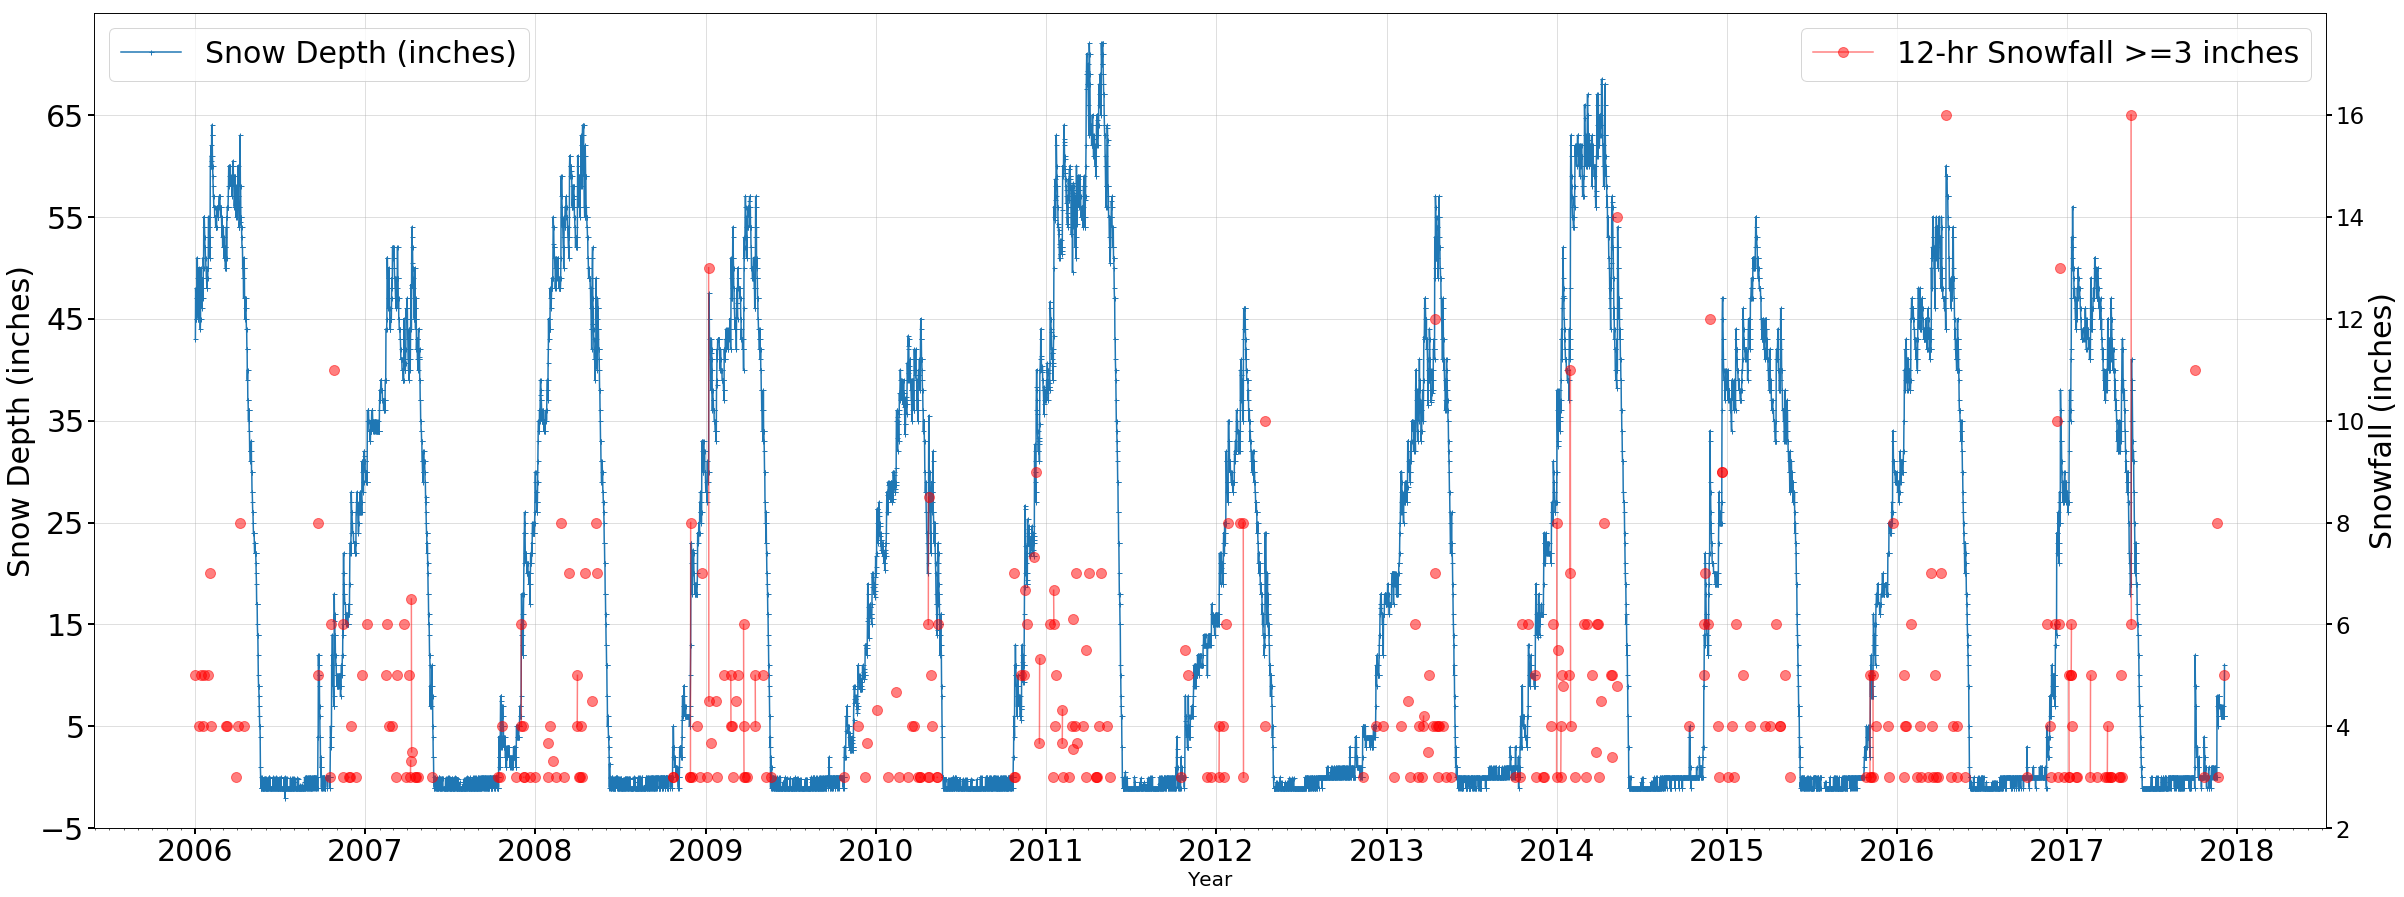

In [6]:

import matplotlib.dates as mdates

fig, ax1 = plt.subplots(figsize=(40,15))
ax2 = ax1.twinx()
#ax1.plot(asos_snotel_UA_df['CMtnSNTL_SnowDepth_in']['04-16-2009':'04-19-2009'], marker='.', markersize = 10, label = "1hr Snow Depth")

ax1.plot(asos_snotel_UA_df['CMtnSNTL_12hr_SNWD_in']['2006':'2017'], marker='+', markersize = 5, label = "Snow Depth (inches)")
ax2.plot(asos_snotel_UA_df['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']['2006':'2017'], marker='.', markersize = 20, alpha = 0.5,  label = "12-hr Snowfall >=3 inches" , color = 'r')

ax2.set_yticks(np.arange(2,18,2))
ax1.set_yticks(np.arange(-5,75,10))
#ax2.set_yticks([2,4,6,7,8,9,10,11,12,13,14,15,16,17,18])
#ax1.set_yticks([-5,5, 15,25,35,45,55,65,75])

numsteps = 9
#ax2.set_yticks(np.linspace(ax2.yaxis.min(),ax2.yaxis.max(),numStep))
#ax1.set_yticks(np.linspace(ylim()[0],ylim()[1],numSteps))

ax1.set_ylim(-5,75)
ax2.set_ylim(2,18)

ax1.grid(True)


ax1.legend(loc='upper left', fontsize = 30)
ax2.legend(loc='upper right', fontsize = 30)

ax1.set_ylabel('Snow Depth (inches)', size = 30)
ax2.set_ylabel('Snowfall (inches)', size = 30)

ax1.set_xlabel('Year', size=20)
ax1.tick_params(direction='out', length=6, width=2, grid_alpha=0.5, labelsize=30)

ax2.tick_params(direction='out', length=6, width=2, grid_alpha=0.5, labelsize=23)

ax1.xaxis.set_minor_locator(mdates.MonthLocator(interval=1))
ax1.xaxis.set_major_locator(mdates.YearLocator())

#ax1.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 12)))
#ax1.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))  # hours and minutes
#ax1.xaxis.set_major_formatter(mdates.DateFormatter('\n%m-%d-%Y')) 


print(asos_snotel_UA_df['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'].describe())
fig.savefig(r'C:\Users\RAPP\Documents\Capstone\Report\figs\snowdepth_snowfall.png', bbox_inches='tight')


255
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
| Year           |   # of Events with Met |   Poss # of Events |   Mean |   Median |   Max |   Std Deviation |
|----------------|------------------------|--------------------|--------|----------|-------|-----------------|
| 2006           |                     21 |                 26 |    5   |      5   |  11   |            2.05 |
| 2007           |                     23 |                 29 |    3.9 |      3.3 |   6.5 |            1.18 |
| 2008           |                     25 |                 27 |    4.3 |      3.3 |   8   |            1.84 |
| 2009           |                     16 |                 27 |    3.9 |      3.8 |   6   |            0.87 |
| 2010           |                     20 |                 30 |    4.4 |      3.8 |   9   |            1.77 |
| 2011           |                     23 |                 32 |    4.3 |      4   |   7   |            1.33 |
| 2012           |                      5 |  

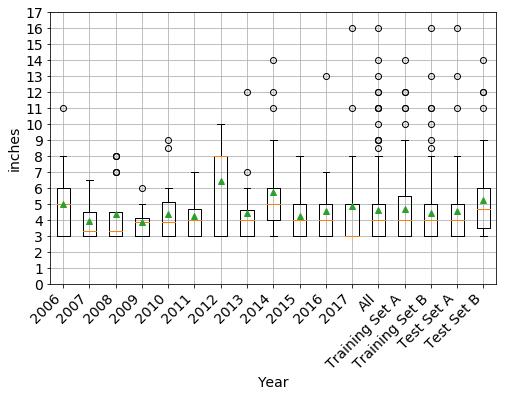

In [15]:
import statistics as sts
all_yrs_tt = (test_train_df.index >= '01-01-2006') & (test_train_df.index < '01-01-2018')
test_yrs_tt_A=  (test_train_df.index >= '01-01-2015') 
train_yrs_tt_A = (test_train_df.index >= '01-01-2006') & (test_train_df.index < '01-01-2015')

train_yrs_tt_B = ((test_train_df.index >= '01-01-2006') & (test_train_df.index < '01-01-2013')) | ((test_train_df.index >= '01-01-2015') & (test_train_df.index < '01-01-2018'))
test_yrs_tt_B = (test_train_df.index >= '01-01-2013') & (test_train_df.index < '01-01-2015')

print(len(train_yrs_tt_A))
from tabulate import tabulate
years = ['2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', all_yrs_tt, train_yrs_tt_A, train_yrs_tt_B, test_yrs_tt_A, test_yrs_tt_B]
year_lbls = ['2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', 'All', 'Training Set A', 'Training Set B', 'Test Set A', 'Test Set B',]
years2 = ['2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', all_yrs, train_yrs_A, train_yrs_B, test_yrs_A, test_yrs_B]
counts = []
means = []
maxes = []
sd_missings =[]
std_devs=[]
medians = []
possible_snf = []
data2plot = []

for year in years:


    counts.append(test_train_df['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][year].count())
    maxes.append((round(test_train_df['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][year].max(),1)))
    means.append(round(test_train_df['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][year].mean(),1))
    medians.append(round(test_train_df['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][year].median(),1))
    
    #sd_missings.append(round(filtered_asos_snotel_UA_df['CMtnSNTL_12hr_SNWD_in'][year].count()/len(filtered_asos_snotel_UA_df['CMtnSNTL_12hr_SNWD_in'][year][idx])/12*100,2))
    std_devs.append(round(np.std(test_train_df['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][year].dropna()),2))
    #print(filtered_asos_snotel_UA_df['CMtnSNTL_12hr_SNWD_in'][year].count(),len(filtered_asos_snotel_UA_df['CMtnSNTL_12hr_SNWD_in'][year])/12)
    data2plot.append(test_train_df['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][year].values.tolist())
   
    
    
#Calculate potential snowfalls
for year in years2:
    possible_snf.append(asos_snotel_UA_df['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][year].count())
    
    
tbl = zip(year_lbls, counts, possible_snf, means, medians, maxes,std_devs )  
fig = plt.figure(figsize=(8,5))

ax = fig.add_subplot(111)

plt.boxplot(data2plot, showmeans=True)  
#plt.title('Box Plot of ' + keys[k])
ax.set_xticklabels(year_lbls, rotation = 45, fontsize = 14, ha = 'right')

v = list(np.arange(0,18,1))
print(v)
ax.set_yticks(v)
ax.set_yticklabels(v, fontsize = 14)
ax.set_xlabel('Year', fontsize = 14)
ax.set_ylabel('inches', fontsize = 14)
#ax.set_ylabel(keys[k])



print(tabulate(tbl, headers=['Year', '# of Events with Met', "Poss # of Events", 'Mean', 'Median','Max',  'Std Deviation'], tablefmt='github'))
print(medians)
plt.grid(True)

plt.savefig('C:/Users/RAPP/Documents/Capstone/Report/figs/model_snowfall.png', bbox_inches='tight')


print(v)

         year_lbls  counts  possible_snf  means  medians  maxes  std_devs
0             2006      21            26    5.0      5.0   11.0      2.05
1             2007      23            29    3.9      3.3    6.5      1.18
2             2008      25            27    4.3      3.3    8.0      1.84
3             2009      16            27    3.9      3.8    6.0      0.87
4             2010      20            30    4.4      3.8    9.0      1.77
5             2011      23            32    4.3      4.0    7.0      1.33
6             2012       5            14    6.4      8.0   10.0      2.87
7             2013      23            32    4.4      4.0   12.0      1.94
8             2014      37            37    5.7      5.0   14.0      2.57
9             2015      21            23    4.2      4.0    8.0      1.27
10            2016      19            32    4.6      4.0   13.0      2.37
11            2017      22            29    4.9      3.0   16.0      3.14
12             All     255           3

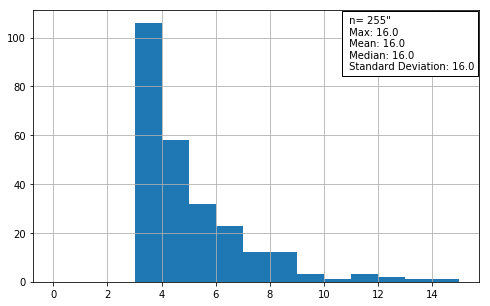

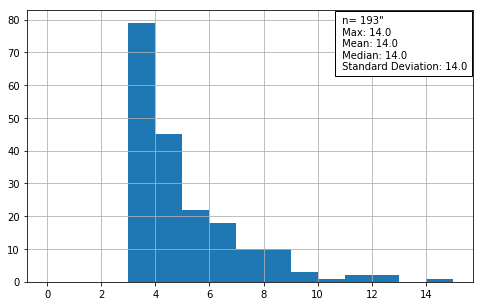

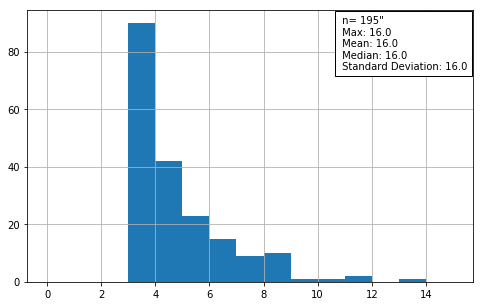

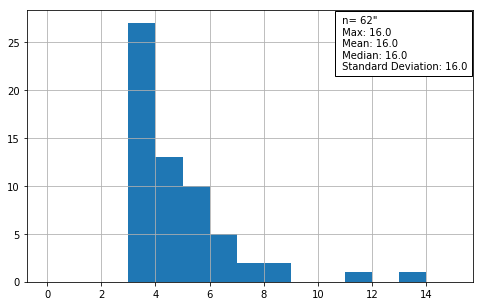

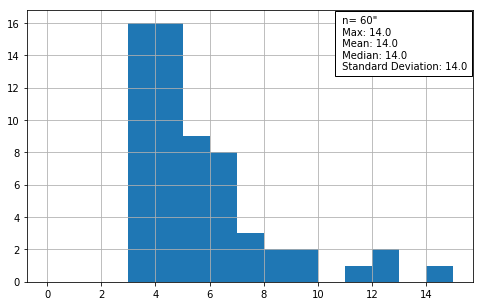

In [16]:
df = pd.DataFrame()
df = pd.DataFrame(list(zip(year_lbls, counts, possible_snf, means, medians, maxes,std_devs))  , columns = ['year_lbls', 'counts', 'possible_snf', 'means', 'medians', 'maxes','std_devs'])
print(df)
df.set_index('year_lbls', inplace = True)
print(df)
print(df['means']['2006'])

year_dict = dict(zip(['All', 'Training Set A', 'Training Set B', 'Test Set A', 'Test Set B',], [all_yrs_tt, train_yrs_tt_A, train_yrs_tt_B, test_yrs_tt_A, test_yrs_tt_B])) 

print(year_dict['All'])
for year_lbl in year_dict.keys():

  
  hist = test_train_df['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][year_dict[year_lbl]].hist(figsize=(8,5), bins = np.arange(0,16,1))
  plt.annotate(' n= ' + str(round(df['counts'][year_lbl],0)) + '"' + \
               '\n Max: ' + str(round(df['maxes'][year_lbl],1)) + \
               '\n Mean: ' + str(round(df['maxes'][year_lbl],1)) + \
               '\n Median: ' + str(round(df['maxes'][year_lbl],1))+ \
               '\n Standard Deviation: ' + str(round(df['maxes'][year_lbl],1)), \
                  fontsize=10, bbox=dict(facecolor='white', edgecolor='black'), xy=(0.7, 0.78), xycoords='axes fraction')

  plt.show()


[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  T

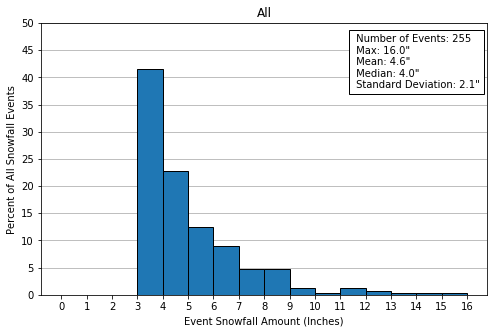

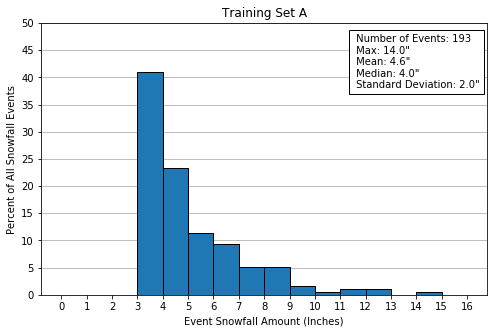

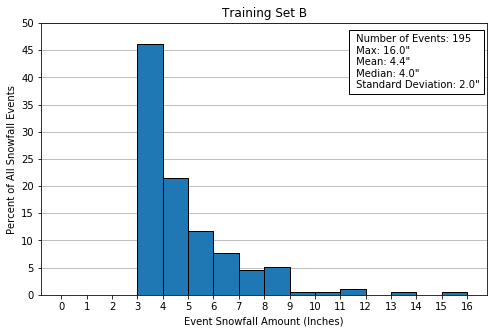

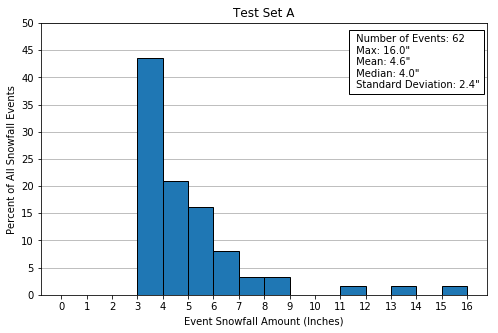

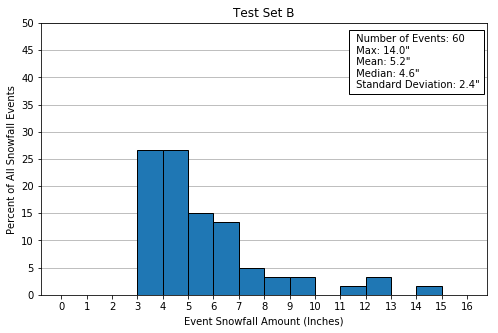

In [17]:

year_dict = dict(zip(['All', 'Training Set A', 'Training Set B', 'Test Set A', 'Test Set B',], [all_yrs_tt, train_yrs_tt_A, train_yrs_tt_B, test_yrs_tt_A, test_yrs_tt_B])) 

print(year_dict['All'])
for year_lbl in year_dict.keys():

  fig = plt.figure(figsize=(8,5))
  ax = plt.subplot(1,1,1)
  weights = np.ones_like(test_train_df['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][year_dict[year_lbl]])/float(len(test_train_df['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][year_dict[year_lbl]]))

  
  plt.hist(test_train_df['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][year_dict[year_lbl]], histtype = 'bar', weights=weights*100, \
           bins = np.arange(0,17,1), align = 'mid', edgecolor = 'black') 
  plt.annotate(' Number of Events: ' + str(round(df['counts'][year_lbl],0)) +  \
               '\n Max: ' + str(round(df['maxes'][year_lbl],1)) + '"' + \
               '\n Mean: ' + str(round(df['means'][year_lbl],1)) + '"' + \
               '\n Median: ' + str(round(df['medians'][year_lbl],1))+ '"' + \
               '\n Standard Deviation: ' + str(round(df['std_devs'][year_lbl],1))+ '"' , \
                 xy=(0.70, 0.76), xycoords='axes fraction', fontsize=10, \
                 bbox=dict(facecolor='white', edgecolor='black'))




  plt.xticks(np.arange(0,17,1))
  plt.ylabel('Percent of All Snowfall Events')
  plt.xlabel('Event Snowfall Amount (Inches)' )
  plt.ylim(0,50)
  plt.yticks(np.arange(0,55,5))
  ax.set_axisbelow(True)
  plt.grid(True, axis = 'y')

  plt.savefig('C:/Users/RAPP/Documents/Capstone/Report/figs/snowfall_histogram_'+ str(year_lbl) + '.png', bbox_inches='tight')

  plt.title(year_lbl)
  plt.show()
#ax.set_yticklabels(np.arange(0,50,10), fontsize = 14)